In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
import sklearn
import theano.tensor as tt
import theano
import pymc3 as pm
import statsmodels.formula.api as smf
import arviz as az


plt.rc("font", size=15)


pylab.rcParams['figure.figsize'] = 5, 5


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

Imagine you end up with the following dataset. You would like to fit those timeseries but by the look of it maybe all of those time series can't be model the same way.

If you had a covariate that would tell you that there is indeed different group in your dataset then things get easy : you can do the fit only on a subset of timeseries or you could perform a mixture of effect modeling.

But let's say that in our case you don't have access to that covariable and you don't even know how many groups there are.

Group based modeling trajectory can help! Basically it's a mixture model, just like gaussian mixture but instead of grouping points as a mixture of gaussian, your group trajectories as a mixture of generalized linear model!

Easy to perform with pymc3!

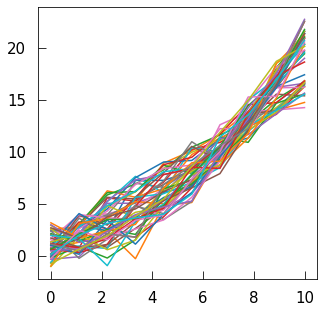

In [108]:
t=np.linspace(0,10,10)
y=[]
for p in range(20):
    # a linear function of t
    y+=[[1+1.5*i+np.random.randn() for i in t]]
for p in range(30):
    # a quadractic function of t
    y+=[[1+0.2*i**2+np.random.randn() for i in t]]
for i in y:    
    plt.plot(t,i)
    
plt.show()

Let's statr by hypothetizing that there are only two groups of trajectories

(10, 2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_coeff2, t_coeff1, intercept2, intercept1, sigma, p]


Sampling 4 chains for 1_500 tune and 5_000 draw iterations (6_000 + 20_000 draws total) took 91 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


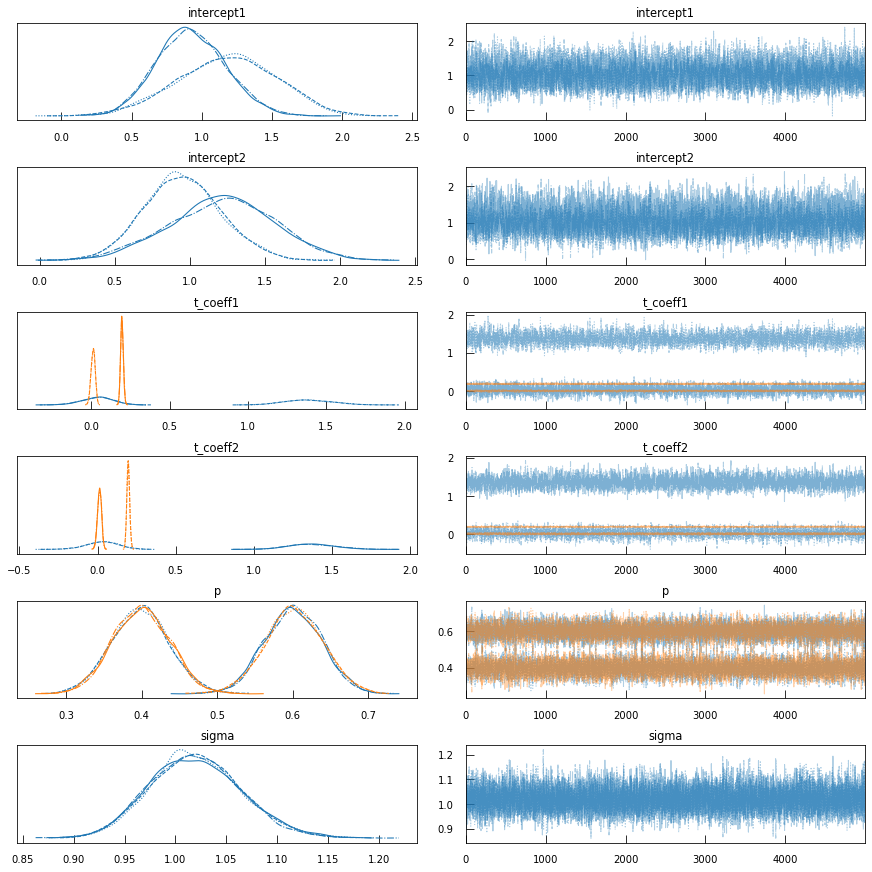

In [110]:
y=np.array(y)
t1=t
t2=t**2
k=2

final_t=np.vstack([t1,t2]).T
print(final_t.shape)
model_2 = pm.Model()
with model_2:
    
    # You sample a Dirichlet distribution to get your mixture weights
    p = pm.Dirichlet("p", a=np.array([1. for i in range(k)]), shape=k)
    
    #Here I am just making sure that there is always 2 models : 
    #you don't want to have one of those p to be zero...
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))
   
    #You sample your coefficient for the pool fits(all the timeseries are fitted using the same priors)
    #(you could go for a mixed effect modelling but here we pool everything together)
    #The priors here are normal so it will be similar to a L2 regularized glm
    sd= pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept1 = pm.Normal("intercept1", 0, sigma=3)
    intercept2 = pm.Normal("intercept2", 0, sigma=3)
    t_coeff1 = pm.Normal("t_coeff1", 0, sigma=3,shape=(final_t.shape[1],1))
    t_coeff2 = pm.Normal("t_coeff2", 0, sigma=3,shape=(final_t.shape[1],1))
    
    
    #You calculate the expected value of your target variable 
    means11 = intercept1 + pm.math.dot(final_t,t_coeff1)
    means22 = intercept2 + pm.math.dot(final_t,t_coeff2)
    
    #You model your target following a basic glm (here normal) 
    first_=pm.Normal.dist(mu=means11, sigma=sd)
    second_=pm.Normal.dist(mu=means22, sigma=sd)
    
    means=[first_,second_]
    
    
    
    #you put those models within a Mixture likelihood function, just like what you would do for a Gaussian mixture.
    like = pm.Mixture('like', w=p, comp_dists = means, observed=y.T)
    trace2=pm.sample(5000,tune=1500,target_accept=0.95,chains=4)
    pm.plots.traceplot(trace2)
    plt.show()

I ran 4 chains in parallel just to check the convergence of the simulation. Convergence there is as the different curves sat on top of each others. The only problem that I see with pymc3 right now is that it doesn't break the symmetry between the models : this is why you have 2 distribution for intercept 1 .  Those 2 distributions are identical to the two distribution in intercept2. PYMC3 swithc the name of the intercept....sometime the first model it works with is the one with intercept1 sometime it is the one with intercept2.... 

In [ ]:
## looking for 3 groups fail as probably their is no realization of a 3 grouping mixture that give those data.

k=3

final_t=np.vstack([t1,t2]).T
print(final_t.shape)
model_3 = pm.Model()
with model_3:
    
    
    p = pm.Dirichlet("p", a=np.array([1. for i in range(k)]), shape=k)
    
    
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))
   
    
    sd= pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept1 = pm.Normal("intercept1", 0, sigma=3)
    intercept2 = pm.Normal("intercept2", 0, sigma=3)
    intercept3 = pm.Normal("intercept3", 0, sigma=3)
    t_coeff1 = pm.Normal("t_coeff1", 0, sigma=3,shape=(final_t.shape[1],1))
    t_coeff2 = pm.Normal("t_coeff2", 0, sigma=3,shape=(final_t.shape[1],1))
    t_coeff3 = pm.Normal("t_coeff3", 0, sigma=3,shape=(final_t.shape[1],1))
    
    
    
    means11 = intercept1 + pm.math.dot(final_t,t_coeff1)
    means22 = intercept2 + pm.math.dot(final_t,t_coeff2)
    means33 = intercept3 + pm.math.dot(final_t,t_coeff3)
    
    
    first_=pm.Normal.dist(mu=means11, sigma=sd)
    second_=pm.Normal.dist(mu=means22, sigma=sd)
    third_=pm.Normal.dist(mu=means33, sigma=sd)
    
    means=[first_,second_,third_]
    
    
    
    
    like = pm.Mixture('like', w=p, comp_dists = means, observed=y.T)
    trace3=pm.sample(5000,tune=1500,target_accept=0.95,chains=4)
    pm.plots.traceplot(trace3)
    plt.show()

The one group model is just a basic glm

(10, 2)


/home/seb/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_coeff1, intercept1, sigma]


Sampling 4 chains for 1_500 tune and 5_000 draw iterations (6_000 + 20_000 draws total) took 19 seconds.


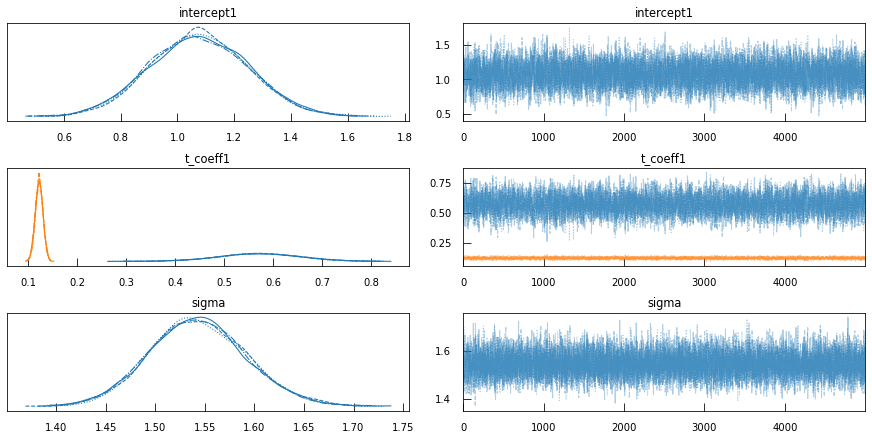

In [111]:
k=1

final_t=np.vstack([t1,t2]).T
print(final_t.shape)
model_1 = pm.Model()
with model_1:
    
    sd= pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept1 = pm.Normal("intercept1", 0, sigma=10)
    
    t_coeff1 = pm.Normal("t_coeff1", 0, sigma=3,shape=(final_t.shape[1],1))
    
    
    
    
    means11 = intercept1 + pm.math.dot(final_t,t_coeff1)
    
    
    like = pm.Normal('like',mu=means11,sigma=sd,observed=y.T)
    
    
    
    
    trace1=pm.sample(5000,tune=1500,target_accept=0.95,chains=4)
    pm.plots.traceplot(trace1)
    plt.show()

To choose between the different models (1 or 2 groups) and typically choose between the numbers of group we use leave one out likelihood estimation.The choice can also be made using the WAIC (Watanabe Aikike information criterion ).I know what the WBIC is and how it generalize the BIC so I guess it it the same for the WAIC that generalizes the AIC. Basically the BIC is a saddle point approximation(around optimal estimation of parameters) of the log likelihood value of the posterior given the distribution of parameters. This approx can often not been made and so the WBIC go back to calculating the full integral instead of the saddle point.

/home/seb/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/home/seb/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/seb/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
2 classes,0,-875.063,7.61655,0,1,14.0489,0,False,log
1 classe,1,-928.032,4.22355,52.9694,2.73328e-13,13.4636,9.34429,False,log


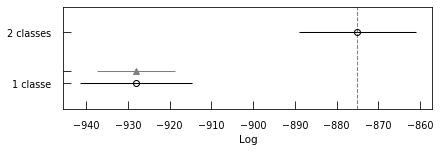

In [112]:
import arviz as az
df_comp_loo = az.compare({"1 classe": trace1,
                          "2 classes": trace2,
                         })
az.plot_compare(df_comp_loo, insample_dev=False)
df_comp_loo

Big win from the 2 groups model as expected (triangle is the $\Delta$WAIC)

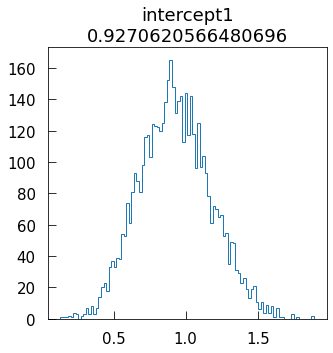

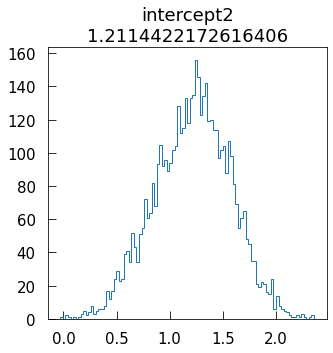

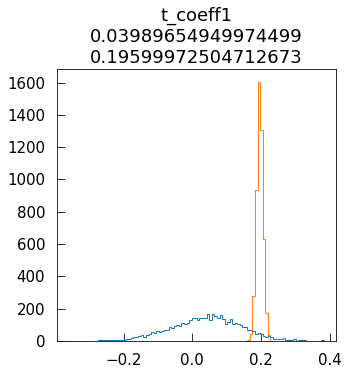

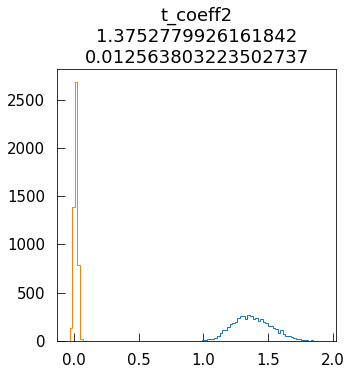

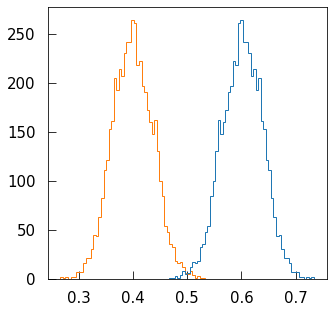

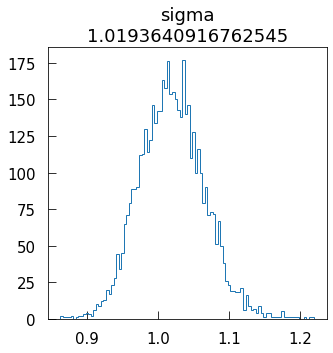

In [113]:
#just getting back one of the MCMC trajectory simulation to actually have the parameters of the model
# by calculating the mean of those different distributions
dico_model={}
for s in ['intercept1','intercept2','t_coeff1','t_coeff2','p','sigma']:
    if 't_' not in s:
        op=trace2[s][15000:20000]
    else:
        op=[trace2[s][15000:20000,0].reshape(5000),trace2[s][15000:20000,1].reshape(5000)]
    
    if s!='p' and 't_' not in s:
        dico_model[s]={'data':op,'mean':np.mean(op),'std':np.std(op)}
        plt.title(s+'\n'+str(dico_model[s]['mean']))
    if 't_' in s :
        dico_model[s]={'data':op,'mean':[np.mean(op[0],axis=0),np.mean(op[1],axis=0)],'std':np.std(op,axis=0)}
        plt.title(s+'\n'+'\n'.join([str(dico_model[s]['mean'][i]) for i in range(len(dico_model[s]['mean']))]))
    if s==p:
        dico_model[s]={'data':op,'mean':np.mean(op,axis=0),'std':np.std(op,axis=0)}
        plt.title(s+'\n'+'\n'.join([str(dico_model[s]['mean'][i]) for i in range(len(dico_model[s]['mean']))]))
    plt.hist(op,100,histtype='step')
    
    plt.show()

In [114]:
models={
    '1':{'func' : lambda x : dico_model['intercept1']['mean']+ dico_model['t_coeff1']['mean'][0]*x+dico_model['t_coeff1']['mean'][1]*x**2, 'sigma':dico_model['sigma']['mean']},
    '2':{'func' : lambda x : dico_model['intercept2']['mean']+ dico_model['t_coeff2']['mean'][0]*x+dico_model['t_coeff2']['mean'][1]*x**2, 'sigma':dico_model['sigma']['mean']}}

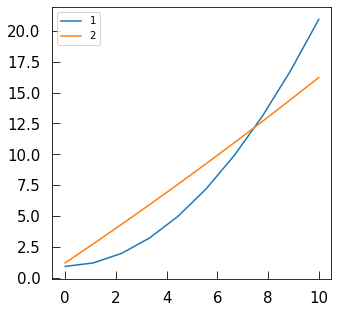

In [115]:
#the two models!!!!
xx=np.linspace(0,10,10)
for s in models.keys():
    plt.plot(xx,models[s]['func'](xx),label=s)
plt.legend(loc='best',fontsize=10)
plt.show()

In [116]:
#maxlikelihood decision function to label our timeserie to one of the 2 groups
from scipy.stats import norm
model_kept_s={}
for s in range(y.shape[0]):
    model_kept_s[s]={'max_like': np.sum([norm.logpdf(v,loc=models['1']['func'](t[tt]),scale=models['1']['sigma']) for tt,v in enumerate(y[s])])
                     ,'classe': '1'}
    
for s in range(y.shape[0]):
    for m in list(models.keys())[1:]:
        pretender= np.sum([norm.logpdf(v,loc=models[m]['func'](t[tt]),scale=models[m]['sigma']) for tt,v in enumerate(y[s])])
        #print(pretender,model_kept_s[s]['max_like'])
        if pretender>model_kept_s[s]['max_like']:
            model_kept_s[s]={'max_like':pretender
                         ,'classe': m}

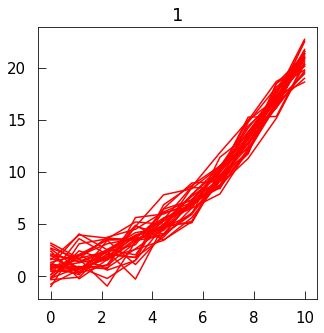

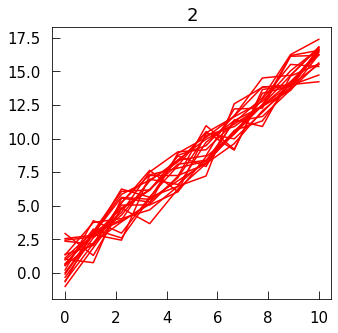

In [117]:
dico_s_to_classe={}
for m in ['1','2']:
    for s in model_kept_s.keys():
        
        yy=np.array([i for i in y[s]])
        if model_kept_s[s]['classe']==m:
            dico_s_to_classe[str(s)]=m
            
            plt.plot(t,yy,color='r')
            
    plt.title(m)
    plt.show()